In [96]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import os
from scipy import stats
import plotly.express as px
import plotly
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#------------GLOBALS-------------
area_rows_to_drop = ['North East', 'North West', 'East Midlands', 'West Midlands',
                   'East', 'London', 'South East', 'South West', 'England', 'Wales',
                   'Scotland', 'Great Britain', 'Inner London', 'Outer London', 'City of London']

RAW_DATA_PATH = "~/library/data/raw/"
PROC_DATA_PATH = '~/library/data/processed/'

business_cols_to_drop = ['births','1_year_survival_number', '1_year_survival_rate', 
                         '2_year_survival_number', '2_year_survival_rate', '4_year_survival_number', 
                         '4_year_survival_rate' ,'5_year_survival_number', '5_year_survival_rate']

shap_arr = []
k2_arr = []
alpha = 0.05
    
#------------FUNCTIONS-------------
def colToDrop(df):
    col_length = len(df.columns)
    arr = []
    for index in range(2, col_length):
        if df.columns[index].find('Jan') != -1:
            if index + 2 < col_length:
                index += 2
            pass
        arr.append(df.columns[index])    
    return arr


def replaceCol(df):
    col_length = len(df.columns)
    mapping = {
        df.columns[0]:'code', 
        df.columns[1]:'area'
    }
    
    for index in range(2, col_length):
        if index%2!=0:
            mapping[df.columns[index]] = '+/- Difference'
    return mapping


def readCsv(*args):
    try:
        if args[0] != "":
            path = args[0]
    except:
        print('Null/empty path variable given')
   
    try:
        sep = args[1]
    except IndexError:
        print('tuple index out of range. Separator values need to be specified')
    
    
    if len(args) < 3:
        na_values = []
    else:
        na_values = args[2]
    
    df = pd.read_csv(RAW_DATA_PATH + path, sep=sep, na_values=na_values)
    return df

In [97]:
import matplotlib.rcsetup as rcsetup
print(rcsetup.all_backends)

['GTK3Agg', 'GTK3Cairo', 'MacOSX', 'nbAgg', 'Qt4Agg', 'Qt4Cairo', 'Qt5Agg', 'Qt5Cairo', 'TkAgg', 'TkCairo', 'WebAgg', 'WX', 'WXAgg', 'WXCairo', 'agg', 'cairo', 'pdf', 'pgf', 'ps', 'svg', 'template']


In [98]:
plotly.offline.init_notebook_mode(connected=True)

In [99]:
df_1 = readCsv('business-survival-rates.csv', ',', [':']) 
df_2 = readCsv('Jobs and Job Density.csv', ',') 
df_3 = readCsv('mb-unemployment-rates.csv', ',', [' ', '-'])

In [100]:
df_4 = pd.read_csv(PROC_DATA_PATH + 'processed_nvq4-qualifications-overtime.csv', sep = ',')

In [122]:
df_5 = pd.read_csv(PROC_DATA_PATH + 'processed_youth-claimants-rate.csv')

In [137]:
df_6 = pd.read_csv(PROC_DATA_PATH + 'processed_no-qualifications-overtime.csv', sep=',')
df_7 = pd.read_csv(PROC_DATA_PATH + 'processed_qualifications-average-2014.csv', sep=',')

In [101]:
df_1.drop(business_cols_to_drop, inplace=True, axis=1)

In [102]:
df_1.dropna(inplace=True, axis=0, how='any')
df_3.dropna(inplace=True, axis=0, how='any')
mapping = replaceCol(df_3)
df_3.rename(columns=mapping, inplace=True)
df_3 = df_3.reset_index(drop=True)
df = pd.merge(df_1, df_2, on=['code','area', 'year'])

In [103]:
df_3.drop(colToDrop(df_3), inplace=True, axis=1)

In [104]:
df_3 = df_3.melt(id_vars=["code", "area"], 
        var_name="Date", 
        value_name="Value")

In [105]:
df_3['Date'] = df_3['Date'].apply(lambda x: [int(s) for s in str.split(x) if s.isdigit()][0])

In [106]:
df_3.rename(columns={'Date':'year', 'Value':'unemployment_rate'}, inplace=True)

In [107]:
df = pd.merge(df, df_3, on=['code','area', 'year'])

In [108]:
df['unemployment_rate'] = df['unemployment_rate'].astype('float')

In [109]:

df = df[~df['area'].isin(area_rows_to_drop)]

In [110]:
df

,code,area,year,3_year_survival_number,3_year_survival_rate,number_of_jobs,job_density,unemployment_rate
0,E09000002,Barking and Dagenham,2004,290.0,60.4,53000,0.51,8.3
1,E09000003,Barnet,2004,1385.0,56.9,135000,0.63,6.3
2,E09000004,Bexley,2004,565.0,60.1,85000,0.61,4.1
3,E09000005,Brent,2004,995.0,55.3,119000,0.65,9.1
4,E09000006,Bromley,2004,1015.0,63.8,126000,0.67,4.7
5,E09000007,Camden,2004,1810.0,63.7,278000,1.82,7.6
6,E09000008,Croydon,2004,1000.0,61.3,153000,0.69,6.2
7,E09000009,Ealing,2004,1210.0,57.2,136000,0.63,6.5
8,E09000010,Enfield,2004,855.0,61.1,110000,0.59,6.6
9,E09000011,Greenwich,2004,590.0,60.5,77000,0.50,8.0


In [111]:
#TODO move this into EDA
for col in range(3, len(df.columns)):
    
    stat, p = stats.shapiro(df[df.columns[col]])

    if p <= alpha:
        shap_arr.append((df.columns[col], stat, p))
        print("Shapiro-Wilk's Test not passed (reject H0)", end='\n')

    stat, p = stats.normaltest(df[df.columns[col]])

    if p <= alpha:
        k2_arr.append((df.columns[col], stat, p))
        print('D’Agostino’s K^2 Test not passed (reject H0)', end='\n')

if len(shap_arr)!= 0:
    print(shap_arr, end='\n')
print()
if len(k2_arr)!= 0:
    print(k2_arr, end='\n')

Shapiro-Wilk's Test not passed (reject H0)
D’Agostino’s K^2 Test not passed (reject H0)
Shapiro-Wilk's Test not passed (reject H0)
D’Agostino’s K^2 Test not passed (reject H0)
Shapiro-Wilk's Test not passed (reject H0)
D’Agostino’s K^2 Test not passed (reject H0)
Shapiro-Wilk's Test not passed (reject H0)
D’Agostino’s K^2 Test not passed (reject H0)
[('3_year_survival_number', 0.7546795606613159, 1.5993066856395534e-22), ('number_of_jobs', 0.6049059629440308, 1.3664620289068184e-27), ('job_density', 0.5705618262290955, 1.559186901398484e-28), ('unemployment_rate', 0.9828338623046875, 0.0003330041654407978)]

[('3_year_survival_number', 215.33986135991458, 1.7359740895682453e-47), ('number_of_jobs', 277.82729424569425, 4.683489959161023e-61), ('job_density', 285.6185620349868, 9.521761289872142e-63), ('unemployment_rate', 10.20722373637578, 0.006074765640544019)]


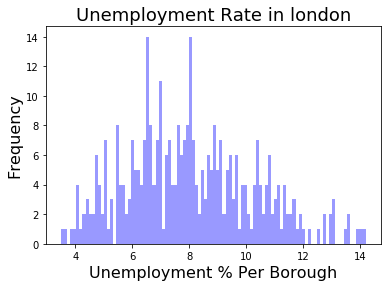

In [17]:
#TODO think if you need this or not. Doesn't seem very helpful atm.
hplot = sns.distplot(df['unemployment_rate'], kde=False, color='blue', bins=100)
plt.title('Unemployment Rate in london', fontsize=18)
plt.xlabel('Unemployment % Per Borough', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plot_file_name="Unemployment_rate_in_london_by_borough.jpg"
hplot.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)

AttributeError: module 'seaborn' has no attribute 'title'

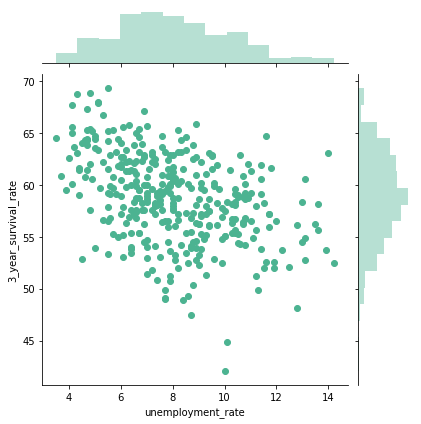

In [28]:
#TODO move to EDA or get rid of it
sns.jointplot(x='unemployment_rate',y='3_year_survival_rate',data=df,color="#4CB391")
sns.title('Unemployment vs 3 Year Survival Rate of businesses in London (in percentages)', fontsize=13)
sns.ylabel('Survival', fontsize=16)
sns.xlabel('Unemployment', fontsize=16)

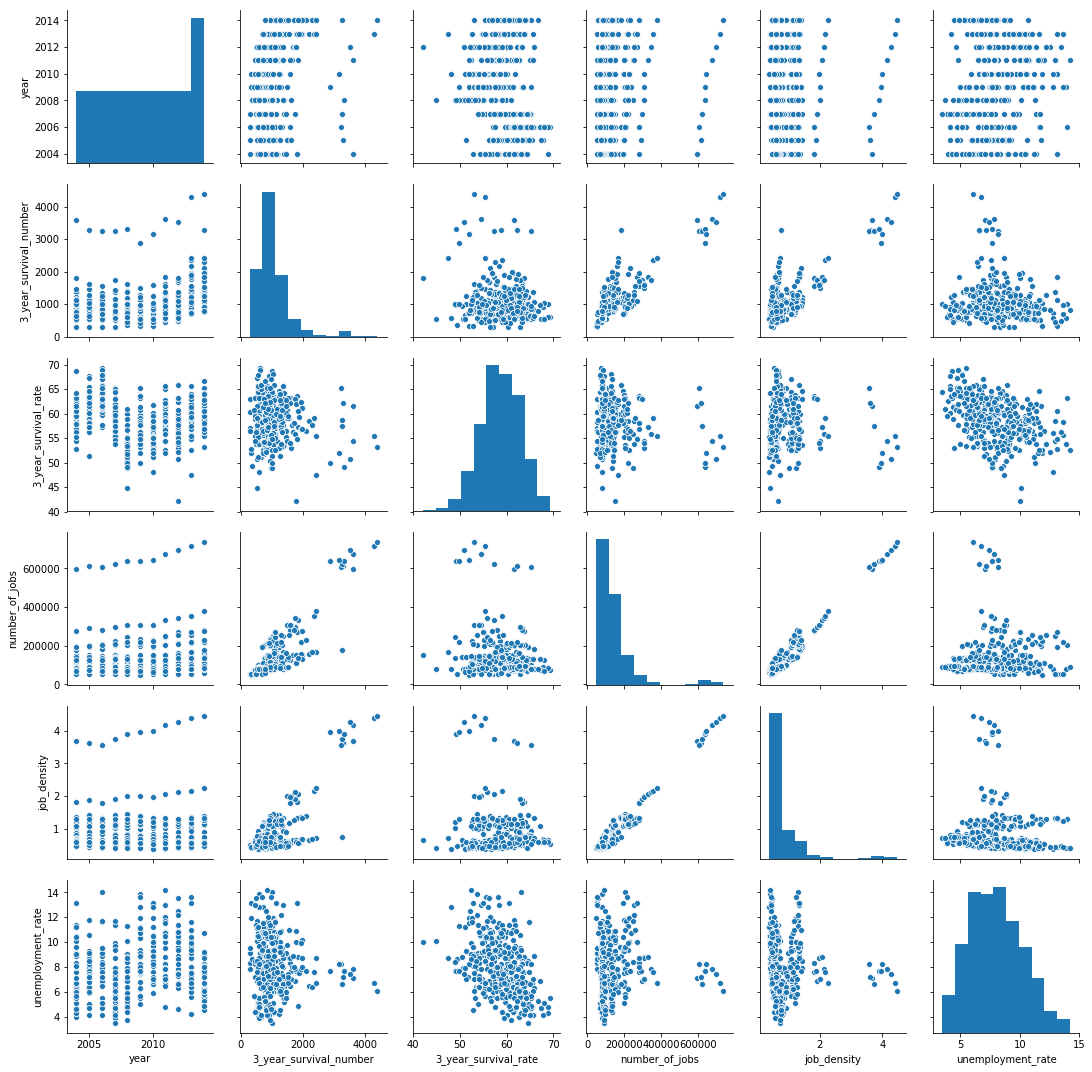

In [29]:
#TODO add geographic zones so we can visualise this more easily. Move to EDA
sns.pairplot(data=df)

In [199]:
#TODO check whether scatter matrix or pairplot is better. Move to EDA
outliers_to_drop = ['Camden', 'Westminster']

df = df[~df['area'].isin(to_drop)]
fig = px.scatter_matrix(df, dimensions=['unemployment_rate','3_year_survival_rate','job_density',], color="area")
fig.show()

In [112]:
df_4.drop(['Unnamed: 0'], axis=1, inplace=True)

In [113]:
df_4.dropna(how='any', inplace=True)

In [114]:
df_4.rename(columns={'Code':'code', 'Area':'area'}, inplace=True)

In [115]:
df_4 = df_4.melt(id_vars=["code", "area"], 
        var_name="year", 
        value_name="NVQ4_rate")

In [116]:
df_4['year'] = df_4['year'].astype('int64')

In [118]:
df = pd.merge(df, df_4, on=['area', 'year'])

In [133]:
df.rename(columns={'code_x':'code'}, inplace=True)

In [121]:
df.drop(['code_y'], axis=1, inplace=True)

In [123]:
df_5.drop(['Unnamed: 0'], axis=1, inplace=True)

In [124]:
df_5.dropna(how='any', inplace=True)

In [125]:
df_5.rename(columns={'Code':'code', 'Area':'area'}, inplace=True)

In [126]:
df_5 = df_5[~df_5['area'].isin(area_rows_to_drop)]

In [127]:
df_5 = df_5.melt(id_vars=["code", "area"], 
        var_name="year", 
        value_name="youth_unemployment_rate")

In [128]:
df_5['year'] = df_5.loc[:,'year'].astype('int64')

In [129]:
df_5.dtypes

code                        object
area                        object
year                         int64
youth_unemployment_rate    float64
dtype: object

In [135]:
df = pd.merge(df, df_5, on=['area', 'year', 'code'])

In [139]:
df_6.drop(['Unnamed: 0'], axis=1, inplace=True)
df_6.dropna(how='any', inplace=True)
df_6.rename(columns={'Code':'code', 'Area':'area'}, inplace=True)
df_6 = df_6.melt(id_vars=["code", "area"], 
        var_name="year", 
        value_name="no_qualif_rate")
df_6['year'] = df_6['year'].astype('int64')
df = pd.merge(df, df_6, on=['area', 'year'])

In [143]:
df.drop(['code_y'], axis=1, inplace=True)
df.rename(columns={'code_x':'code'}, inplace=True)

In [144]:
df.to_csv(PROC_DATA_PATH + 'borough-unemployment-and-business-data.csv')

In [66]:
df["unemployment_rate_r"] = df['unemployment_rate'].rank()
df["3_year_survival_rate_r"] = df['3_year_survival_rate'].rank()
df['job_density_r'] = df['job_density'].rank()

In [77]:
df['NVQ4_rate_r'] = df['NVQ4_rate'].rank()

In [78]:
np.corrcoef(df['unemployment_rate_r'], df['NVQ4_rate_r'])

array([[1.        , 0.01379716],
       [0.01379716, 1.        ]])

In [67]:
np.corrcoef(df['unemployment_rate_r'], df['job_density_r'])

array([[ 1.        , -0.24094071],
       [-0.24094071,  1.        ]])

In [68]:
np.corrcoef(df['unemployment_rate_r'], df['3_year_survival_rate_r'])

array([[ 1.        , -0.43170871],
       [-0.43170871,  1.        ]])